<a href="https://colab.research.google.com/github/danielthomas06/Food101---DeepLearning/blob/main/05_transfer_learner_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow: Fine Tuning

In [ ]:
#Check if GPU is connected
!nvidia-smi

Sun Jun 27 11:43:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
### Creating helper function
!wget  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

#Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2021-06-27 11:43:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-27 11:43:10 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Get the data
This time we are going to see how we can use preprained models within tf.keras.applications and applyt them to our own priblem (recognizing images of food).

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-06-27 11:43:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   182MB/s    in 0.9s    

2021-06-27 11:43:13 (182 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [ ]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE=32
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode="categorical",
                                                                    batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size= BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check out the class names of our dataset
train_data_10.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.27326530e+02 2.50969391e+02 2.52841843e+02]
   [1.27739792e+02 2.54785721e+02 2.48637756e+02]
   [1.44056122e+02 2.49198990e+02 2.36127548e+02]
   ...
   [2.51066422e+02 2.54862259e+02 1.99628082e+02]
   [2.52928558e+02 2.54234665e+02 2.38903198e+02]
   [2.52285721e+02 2.50744904e+02 2.54586761e+02]]

  [[1.38362244e+02 2.50382660e+02 2.53071426e+02]
   [1.45066330e+02 2.49408157e+02 2.46545914e+02]
   [1.72112244e+02 2.47826538e+02 2.42826538e+02]
   ...
   [2.53357208e+02 2.55000000e+02 1.80597382e+02]
   [2.53061218e+02 2.53994888e+02 2.11520493e+02]
   [2.55000000e+02 2.54908173e+02 2.29760376e+02]]

  [[1.51693878e+02 2.54214279e+02 2.55000000e+02]
   [1.67637756e+02 2.46785721e+02 2.47387756e+02]
   [2.07556122e+02 2.49219391e+02 2.49724503e+02]
   ...
   [2.49877548e+02 2.52448975e+02 1.43586975e+02]
   [2.49642868e+02 2.51673492e+02 1.65357254e+02]
   [2.53132706e+02 2.54280640e+02 1.82775635e+02]]

  ...

  [[1.27000000e+02 1.30000000e+02 1.37000000e+02]
   [1

### Model 0: Building a transfer learning model using the KEras Functional API

Functional API gives more flexibility with our model.

In [ ]:
#1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so the undelying pre-trained patterns aren't updated)
base_model.trainable = False

#3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

#4. If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

#8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10. Fit the model
history_10_percent = model_0.fit(train_data_10,
            epochs=5,
            steps_per_epoch=len(train_data_10),
            validation_data=test_data,
            validation_steps= int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extarction")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extarction/20210627-114323
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 306ms/step - loss: 1.8549 - accuracy: 0.4347 - val_loss: 1.2952 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 5s 197ms/step - loss: 1.1110 - accuracy: 0.7547 - val_loss: 0.8899 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 5s 193ms/step - loss: 0.8269 - accuracy: 0.7987 - val_loss: 0.7216 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 5s 204ms/step - loss: 0.6647 - accuracy: 0.8467 - val_loss: 0.6483 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 5s 206ms/step - loss: 0.5934 - accuracy: 0.8547 - val_loss: 0.5745 - val_accuracy: 0.8635


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 109ms/step - loss: 0.5976 - accuracy: 0.8468


[0.5976003408432007, 0.8468000292778015]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


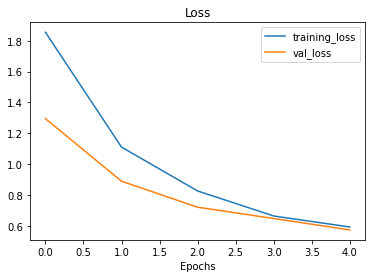

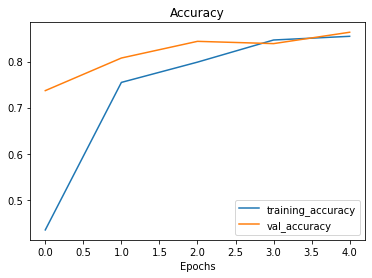

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

### Getting a feature vector from a trained model

Let's demonstrate the Global Average Polling 2D layer..



In [ ]:
# Define the input shape
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

#Pass the random tensor through a gloabl average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled tensor:\n {global_average_pooled_tensor}")

#Check the shape of the tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shaped of polled tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shaped of polled tensor: (1, 3)


In [ ]:
#Let's replicate the GLobal average pooled layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% training data.. 

1. Model_1 - 1% of the training data with data augmentation
2. Model_2 - feature extraction transfer learning with 10% of the training data with data augmentation
3. Model_3 - use fine tuning on 10% training data with data augmentation
4. Model_4 - use fine tuning transfer learning on 100% of training data with data augmentation

Note: Throughout all experiments the same test dataset will be used to evaluate our model.. this ensures constant evaluation metrics.

In [ ]:
# Download and unzip data- preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")



--2021-06-27 11:44:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   240MB/s    in 0.5s    

2021-06-27 11:44:51 (240 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



### Getting and preprocessing our data

In [ ]:
#Create training and test dirs

train_dir_1 = "10_food_classes_1_percent/train"
test_dir_1 = "10_food_classes_1_percent/test"

walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE= 32

train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                    label_mode="categorical",
                                                                    image_size=IMG_SIZE,
                                                                    batch_size= BATCH_SIZE,
                                                                    )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size = IMG_SIZE,
                                                                 batch_size=BATCH_SIZE,
                                                                 )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation into our model

To add data augmetnation right into our models, we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# Create data augmentation stage with horixontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),

], name="data_augmentation")

### Visualise our augmented data


Text(0.5, 1.0, 'Augmented image of ice_cream')

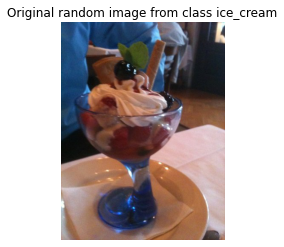

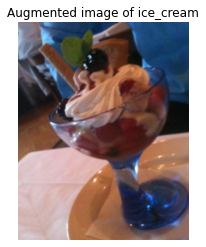

In [ ]:
# Take a random image and visualise before and after data augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

#PLot our augmented data image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False)
plt.title(f"Augmented image of {target_class}")


#print(img)

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="out_layer")(x)

#Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

#Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit the model 
history_1_percent = model_1.fit(train_data_1,
                                epochs=5,
                                steps_per_epoch=len(train_data_1),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name="1_percent_data_aug")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210627-114455


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.4048 - accuracy: 0.0571 - val_loss: 2.2222 - val_accuracy: 0.1530
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1706 - accuracy: 0.1714 - val_loss: 2.0958 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9808 - accuracy: 0.2857 - val_loss: 1.9810 - val_accuracy: 0.3240
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7998 - accuracy: 0.4714 - val_loss: 1.8837 - val_accuracy: 0.3882
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6298 - accuracy: 0.6714 - val_loss: 1.7920 - val_accuracy: 0.4441


In [ ]:
#Check model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
out_layer (Dense)            (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
#Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 9s 105ms/step - loss: 1.8202 - accuracy: 0.4380


[1.8201910257339478, 0.43799999356269836]

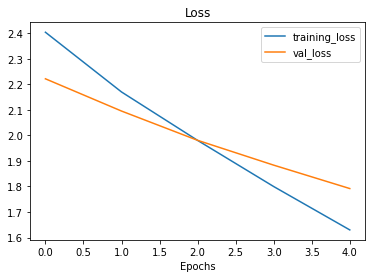

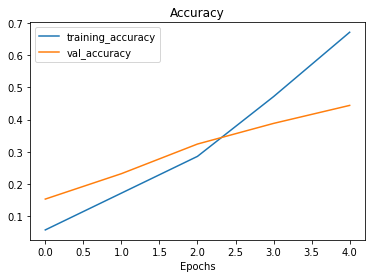

In [ ]:
#How does the model with 1% loss curves look
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data augmentation

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [ ]:
#Set the data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build data data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomRotation(0.2),
                                #preprocessing.Rescale(1./255)
], name="data_augmentation")

imput_shape = (224, 224, 3)

#Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create the inputs and outputs (includeing the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layers")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

#Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])




###Creating a model checkpoints callabck

The ModelCheckPoint callback intermediately saves our model(the full model or just the weights) during training. This is useful so we come and start where we left off)


In [ ]:
#Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints/checkponts.ckpt"

#Create a ModelCHeckpoint clalback that saves the weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=False,
                                                          save_freq="epoch",
                                                          verbose=1)

## Fit model 2 passing in the ModelCheckpoint callback


In [ ]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210627-114543
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 630ms/step - loss: 1.9724 - accuracy: 0.3427 - val_loss: 1.5189 - val_accuracy: 0.6184

Epoch 00001: saving model to ten_percent_model_checkpoints/checkponts.ckpt
Epoch 2/5
24/24 [==============================] - 10s 399ms/step - loss: 1.3070 - accuracy: 0.6947 - val_loss: 1.0352 - val_accuracy: 0.7911

Epoch 00002: saving model to ten_percent_model_checkpoints/checkponts.ckpt
Epoch 3/5
24/24 [==============================] - 10s 393ms/step - loss: 1.0078 - accuracy: 0.7453 - val_loss: 0.8355 - val_accuracy: 0.8207

Epoch 00003: saving model to ten_percent_model_checkpoints/checkponts.ckpt
Epoch 4/5
24/24 [==============================] - 10s 393ms/step - loss: 0.8456 - accuracy: 0.7907 - val_loss: 0.7435 - val_accuracy: 0.8240

Epoch 00004: saving model to ten_percent_model_checkpoints/checkponts.ckpt
Epoch 5/5
24/24 [==============================] - 9s 384ms/step - loss: 0.7160 - accuracy: 0.8267 - val_loss: 0.6651 - val_accuracy: 0.82

### Loading in checkpointed weights
Returns a model to a specific checkpoint

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results =model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6625 - accuracy: 0.8264


In [ ]:
import numpy as np
#Check to see if loaded model results are very close to our previous non-loaded model
#np.isclose(np.array(loaded_weights_model_results),np.array(results_10_percent_data_aug))

## Model 3: Fine tuning an existing model with 10% of the data

**Note** : Fine tuning ussually works best *after* training a feature extarction model for a few epochs with large amounts of data

In [ ]:
#Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f8f136d26d0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8f0e361ed0> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f8e17cb7c10> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8e17cac950> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f8e17d167d0> True


In [ ]:
#What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
#How many trainable variables in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
#To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable to true
base_model.trainable = True

#Freeze all layers except for last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile every time we make a change
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #when fine-tuning you typically want to reduce the learning by 10x.
                metrics=["accuracy"])



In [ ]:
#Check which layers are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

#Refit the model(same as model_2 with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int( 0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],#start training from last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210627-114718
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 532ms/step - loss: 0.6395 - accuracy: 0.8320 - val_loss: 0.5227 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 10s 406ms/step - loss: 0.5116 - accuracy: 0.8520 - val_loss: 0.4995 - val_accuracy: 0.8454
Epoch 7/10
24/24 [==============================] - 9s 344ms/step - loss: 0.4335 - accuracy: 0.8707 - val_loss: 0.4650 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - 9s 362ms/step - loss: 0.3866 - accuracy: 0.8973 - val_loss: 0.4682 - val_accuracy: 0.8322
Epoch 9/10
24/24 [==============================] - 9s 368ms/step - loss: 0.3524 - accuracy: 0.9013 - val_loss: 0.4775 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 9s 366ms/step - loss: 0.3284 - accuracy: 0.9160 - val_loss: 0.5278 - val_accuracy: 0.8257


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4748 - accuracy: 0.8424


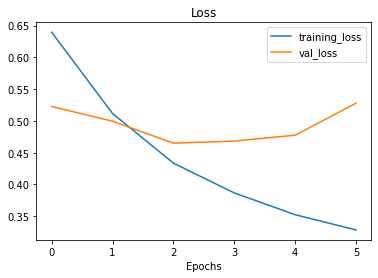

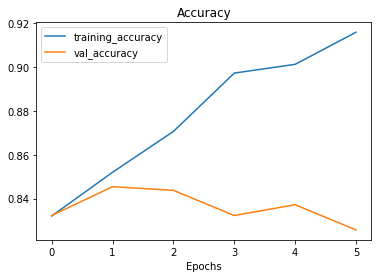

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
#Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):

  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = acc + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  #Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, acc, label="Val Accuracy")
  plt.plot([intial_epochs-1, intial_epochs-1], plt.ylim(), label="Start FIne Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  #Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, acc, label="Val Accuracy")
  plt.plot([intial_epochs-1, intial_epochs-1], plt.ylim(), label="Start FIne Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

ValueError: ignored

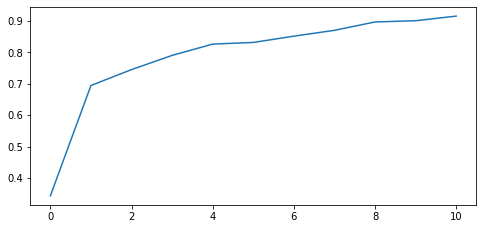

In [ ]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine tuning on existing model on all of the data

In [ ]:
#Download and unzip 10 classes of Food101 data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-06-27 12:06:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 142.250.107.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   242MB/s    in 2.0s    

2021-06-27 12:06:10 (242 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
#Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
#How many images 
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)



Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


To train a fine_tuning model_4 we need to revert model_2 to its feature extraction weights.

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
#Let's evaluate model_2
model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6625 - accuracy: 0.8264


[0.6624710559844971, 0.8263999819755554]

In [ ]:
#Check which all layers are tunable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layers True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs= fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps= int( 0.25 * len(test_data)),
                                           initial_epoch= history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                              experiment_name="full_10_classes_fine_tune_aug")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_aug/20210627-123207
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 60s 255ms/step - loss: 0.6175 - accuracy: 0.8028 - val_loss: 0.3688 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 55s 233ms/step - loss: 0.5116 - accuracy: 0.8371 - val_loss: 0.3355 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 52s 219ms/step - loss: 0.4571 - accuracy: 0.8507 - val_loss: 0.3144 - val_accuracy: 0.8882
Epoch 8/10
235/235 [==============================] - 50s 210ms/step - loss: 0.4131 - accuracy: 0.8675 - val_loss: 0.2906 - val_accuracy: 0.9079
Epoch 9/10
235/235 [==============================] - 46s 192ms/step - loss: 0.3834 - accuracy: 0.8759 - val_loss: 0.3165 - val_accuracy: 0.8882
Epoch 10/10
235/235 [==============================] - 45s 191ms/step - loss: 0.3576 - accuracy: 0.8849 - val_loss: 0.2800 - val_accuracy: 0.8997


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.2849 - accuracy: 0.9064


[0.2849102318286896, 0.9064000248908997]

##Viewing our experiment data on TensorBoard



In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "transfer Learning Experiments with 10 Food101 Classes" \
--description "A series of different transfer learning experiments with varying amounts of data" 


2021-06-27 12:41:41.877376: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3

My tensorboard experiments are available in https://tensorboard.dev/experiment/D4BBDCajTqGb1QrFzBynoA/

In [ ]:
!tensorboard dev list

2021-06-27 12:47:55.518824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/D4BBDCajTqGb1QrFzBynoA/
	Name                 transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data
	Id                   D4BBDCajTqGb1QrFzBynoA
	Created              2021-06-27 12:42:18 (5 minutes ago)
	Updated              2021-06-27 12:42:24 (5 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              198
	Tensor bytes         0
	Binary object bytes  4986703
https://tensorboard.dev/experiment/nVi16bNJQ9udQyG39MjseQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          C